#  This script produces a caaml out of a pnt file:
! the functionality should be implemented in Snowmicorpyn !

- load profile
- compute microparameters
- make clustering on the raw signal and microparameters
- compute macroparameters for the clusters
- output the profile as caaml (with slightly modified document.export_caaml )

In [1]:
import sys
sys.path.append('D:\\SMP_stability\\snowmicropyn')
import snowmicropyn as smpyn
from snowmicropyn.serialize import caaml
from snowmicropyn.ai.grain_classifier import grain_classifier
import pathlib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.integrate import cumulative_trapezoid

## 1. load profile

In [2]:
#prof = Profile.load('snowmicropyn/examples/profiles/S37M0876.pnt')
prof = smpyn.Profile.load('.pnt_data\\190110_BUN\\SMP\\FILE0245.pnt') 

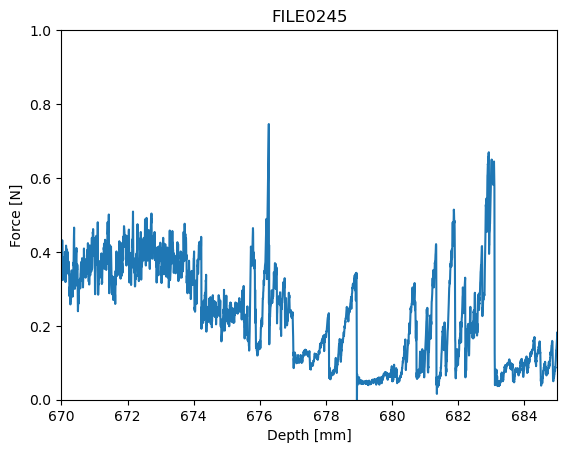

In [3]:
%matplotlib inline


# Plot distance on x and samples on y axis
plt.plot(prof.samples.distance, prof.samples.force)

# Prettify our plot a bit
plt.title(prof.name)
plt.ylabel('Force [N]')
plt.xlabel('Depth [mm]')
plt.ylim(-0.0,1)
plt.xlim(670,685)
# Show interactive plot with zoom, export and other features
plt.show()

## 2. compute microparameters

In [4]:
samples = prof.samples_within_snowpack()
parameterization = "CR2020"
# Prebpare derivatives:
param = smpyn.derivatives.parameterizations[parameterization]
#param.overlap = 50
param.window_size = 2
loewe2012_df = smpyn.loewe2012.calc(samples, param.window_size, param.overlap)
derivatives = loewe2012_df
derivatives = derivatives.merge(param.calc_from_loewe2012(loewe2012_df))
derivatives.profile_bottom = derivatives.distance.iloc[-1]

## 3. make clustering


### Defining the features and weights

In [5]:
# Combine absolute values and derivatives into a feature matrix
features = np.column_stack((derivatives.force_median.values ,
                            derivatives.L2012_f0.values ,
                            derivatives.L2012_delta.values, 
                            derivatives.L2012_L.values, 
                            derivatives.CR2020_ssa.values, 
                            derivatives.CR2020_density.values))



x = derivatives.distance.values

weights = np.array([3,1,1,3,3,1])  # feature weighting, more weight on force, density and SSA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
#scaled_features = scaled_features * weights

### Estimate the Optimal Number of Clusters with Elbow-Method

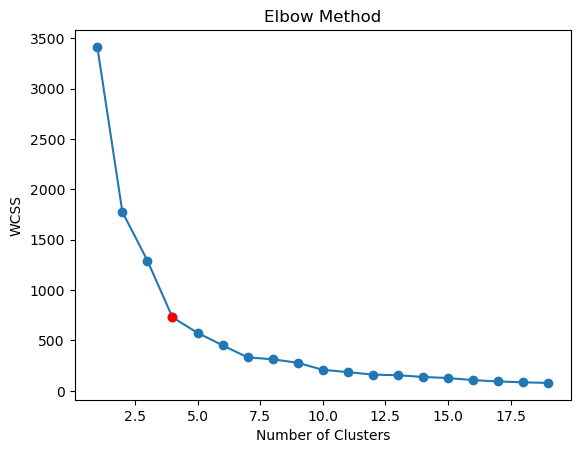

optimal_number_clusters: 4


In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial.distance import euclidean
from scipy.spatial import ConvexHull
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.figure()

# Calculate WCSS for different numbers of clusters
wcss = []
min_cluster,max_cluster = 1, 20
cluster_range = np.arange(1,20)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Straight line connecting endpoints
line_start = np.array([cluster_range[0], wcss[0]])
line_end = np.array([cluster_range[-1], wcss[-1]])
# Calculate distances from each point to the line
distances = []
for i in range(len(cluster_range)):
    point = np.array([cluster_range[i], wcss[i]])
    distance = np.abs(np.cross(line_end-line_start, line_start-point)) / np.linalg.norm(line_end-line_start)
    distances.append(distance)

# Find the point of maximum distance
kink_index = np.argmax(distances)
kink_x = cluster_range[kink_index]
kink_y = wcss[kink_index]
# Plot the Elbow Method
plt.plot(cluster_range, wcss, marker='o')
plt.plot(kink_x,kink_y,marker="o",c="r")
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

opt_number_clusters = kink_x
print("optimal_number_clusters: " + str(opt_number_clusters))

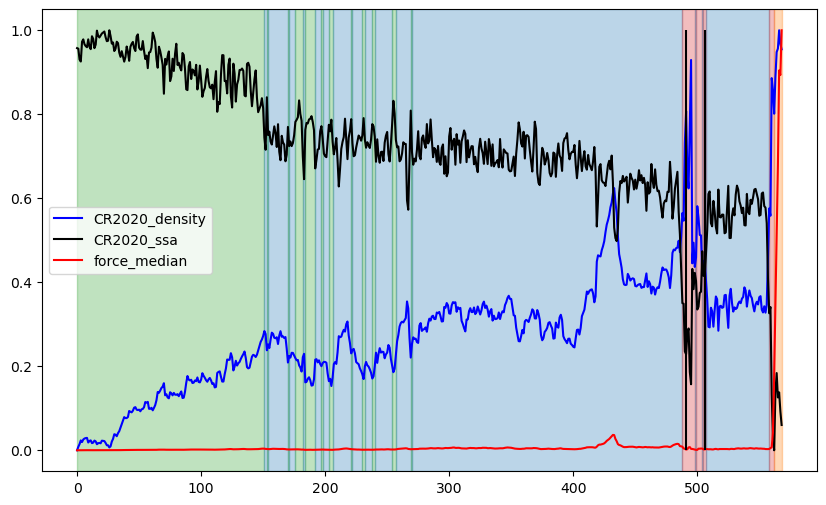

In [7]:
def norm(df):
    return((df - df.min()) / (df.max() - df.min()))

# Use KMeans to cluster based on both features
additional_clusters = 0 # weak layers are sometimes thin and just little weaker as the rest of the layer so we allow more clusters than "necessary"
n_clusters = opt_number_clusters + additional_clusters # Adjust the number of blocks
kmeans = KMeans(n_clusters=n_clusters, random_state=42, )
labels = kmeans.fit_predict(scaled_features)
derivatives["cluster_id"] = labels

# Find boundaries based on clusters
boundaries = [x[0]]  # Start with the first point
for i in range(1, len(labels)):
    if labels[i] != labels[i - 1]:  # If the cluster label changes
        boundaries.append(x[i])
boundaries.append(x[-1])  # Add the last point

# Compute average values in each block
block_values = []
for i in range(len(boundaries) - 1):
    start, end = boundaries[i], boundaries[i + 1]
    mask = (x >= start) & (x < end)
    block_avg = np.mean(derivatives.CR2020_density[mask])
    block_values.append(block_avg)

%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(x, norm(derivatives.CR2020_density), label="CR2020_density", color="blue")
plt.plot(x, norm(derivatives.CR2020_ssa), label="CR2020_ssa", color="k")
plt.plot(x, norm(derivatives.force_median), label="force_median", color="red")
plt.legend()

for i in range(len(boundaries) - 1):
    col = f"C{int(derivatives.loc[derivatives['distance'] == boundaries[i], 'cluster_id'].iloc[0])}"
    plt.axvspan(boundaries[i], boundaries[i + 1], color=col, alpha=0.3, label=f"Block {i+1}")
plt.vlines(prof.markers["wl_t"]-prof.markers["surface"],0,1,colors="k")
plt.vlines(prof.markers["wl_b"]-prof.markers["surface"],0,1,colors="k")
plt.show()

### from cluster_id  to layer_id 

In [8]:
derivatives['layer_id'] = (derivatives['cluster_id'] != derivatives['cluster_id'].shift()).cumsum()

## make means for the layers


In [9]:
layered_derivatives = derivatives.groupby('layer_id').mean()
layered_derivatives["distance"] = derivatives.groupby('layer_id').min().distance # distance is the lower boundary in the snowpack, 0 is surface
layered_derivatives.profile_bottom = derivatives.profile_bottom
layered_derivatives.index = layered_derivatives.index - 1
layered_derivatives = layered_derivatives.rename(columns={'distance': 'depthTop'})
layered_derivatives.profile_bottom = derivatives.profile_bottom

In [10]:
thickness_values = []
for idx, row in layered_derivatives.iterrows():
    if idx == len(layered_derivatives) - 1:
        layer_thickness = layered_derivatives.profile_bottom - row.depthTop
        thickness_values.append(layer_thickness)
    else:
        layer_thickness = layered_derivatives.depthTop[idx + 1] - row.depthTop
        thickness_values.append(layer_thickness)
layered_derivatives['thickness'] = thickness_values
layered_derivatives = layered_derivatives[['depthTop','thickness', 'cluster_id', 'force_median', 'L2012_lambda', 'L2012_f0',
         'L2012_delta', 'L2012_L', 'CR2020_density', 'CR2020_ssa']] # Reorder the DataFrame columns

### unfortunately micromechanical properties is needed to compute mechanical properties.
--> for now we provide a Pickle for the derivatives

maybe at a later stage everthing is provided with  a caaml. However a lot of the derivatives seem to be unnatural for caaml (e.g. strength, elastic modulus, SMP microstructureal parameters...)



### compute weak layer fracture energy

In [11]:
%%time
# Function to compute rolling integral
def rolling_integral(df, window_size):
    half_window = window_size / 2
    distances = df['distance'].values
    forces = df['force'].values
    integrated_values = np.full(len(df), np.nan)
    
    # Use a sliding window approach
    left_idx = np.searchsorted(distances, distances - half_window, side='left')
    right_idx = np.searchsorted(distances, distances + half_window, side='right')
    
    for i in range(len(df)):
        # Ensure full window coverage
        if distances[right_idx[i] - 1] - distances[left_idx[i]] >= 0.99 * window_size:
            integral = cumulative_trapezoid(forces[left_idx[i]:right_idx[i]], distances[left_idx[i]:right_idx[i]], initial=0)
            integrated_values[i] = integral[-1]  # Take the full integral over the window
    
    return integrated_values

# Load sample data
df = prof.samples_within_snowpack()
window_size = 2  # mm

# Compute rolling integral
df["w_f"] = rolling_integral(df, window_size)

# Compute minimum w_f within each layer
w_f = [
    df.loc[(df.distance > row.depthTop) & (df.distance < row.depthTop + row.thickness), "w_f"].min()
    for _, row in layered_derivatives.iterrows()
]

# Store results in layered_derivatives
layered_derivatives["R2015_wf"] = w_f
layered_derivatives["R2015_wf"].attrs = {
    "unit": "mJ",
    "window_size": window_size,
    "info": "Implementation of the Fracture energy of Reuter et al 2015. Note that this has incorrect units."
}

CPU times: total: 3.66 s
Wall time: 3.67 s


### save the layered profile

In [13]:
derivatives.to_pickle(prof._pnt_file.with_name(f'{prof._pnt_file.stem}_smp_ful').with_suffix('.pkl'))
layered_derivatives.to_pickle(prof._pnt_file.with_name(f'{prof._pnt_file.stem}_smp_lay').with_suffix('.pkl'))

In [44]:
layered_derivatives

,depthTop,thickness,cluster_id,force_median,L2012_lambda,L2012_f0,L2012_delta,L2012_L,CR2020_density,CR2020_ssa,R2015_wf
layer_id,,,,,,,,,,,
0,0.0,151.0,2.0,0.056808,17698.511596,0.000491,0.015386,0.107550,122.647854,52.931076,0.051237
1,151.0,2.0,0.0,0.107209,2757.202753,0.001453,0.055193,0.194139,178.249692,39.213565,0.195030
2,153.0,1.0,2.0,0.097344,9263.610460,0.000675,0.031217,0.128455,163.126185,47.184450,0.184025
3,154.0,24.0,0.0,0.089862,2840.876880,0.001515,0.045265,0.194604,167.794202,39.907496,0.143107
4,178.0,3.0,2.0,0.074542,5598.160790,0.001074,0.025673,0.153462,151.158569,44.908198,0.127931
5,181.0,8.0,0.0,0.056729,2753.055933,0.001508,0.035761,0.204604,143.803515,40.895293,0.098746
6,189.0,1.0,2.0,0.051303,3750.439133,0.000925,0.029478,0.173640,132.909396,43.934579,0.099771
7,190.0,41.0,0.0,0.072157,2307.216136,0.001650,0.043166,0.212754,156.844572,39.250133,0.098635
8,231.0,1.0,2.0,0.056564,3764.103914,0.001248,0.024516,0.173429,138.497237,43.599723,0.115151
